<a href="https://colab.research.google.com/github/Ar1n382/gmt-projects-/blob/main/Gmt327_assigment3_2230674038_Ar%C4%B1n_%C3%87ilingir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#İmport the liberies
!pip install cartopy
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import astropy
import math

In [ ]:
# define the elemation rotation matrices and reflection matrices

#x axis
def getR1(alpha):
    return np.matrix([
        [1,0,0],
        [0, np.cos(alpha), np.sin(alpha)],
        [0, -np.sin(alpha), np.cos(alpha)],
    ])
#y axis
def getR2(alpha):
  return np.matrix([
      [np.cos(alpha),0,-np.sin(alpha)],
      [0,1,0],
      [np.sin(alpha),0,np.cos(alpha)]
  ])

#z axis

def getR3(alpha):
  return np.matrix([
      [np.cos(alpha),np.sin(alpha),0],
      [-np.sin(alpha),np.cos(alpha),0],
      [0,0,1]
  ])

In [ ]:
#reflection matrices

#x reflectioıns
def getS1():
  return np.matrix([
      [-1,0,0],
      [0,1,0],
      [0,0,1]
  ])

#y reflections

def getS2():
  return np.matrix([
      [1,0,0],
      [0,-1,0],
      [0,0,1]
  ])

# z reflections
def getS3():
  return np.matrix([
      [1,0,0],
      [0,1,0],
      [0,0,-1]
  ])

In [ ]:
#create the obsever class

class SphericalEarthModel():
  R = 6371000 #m

class Observer():
  def __init__(self, name, lat, lon, height):
    self.name = name
    self.lat = lat
    self.lon = lon

    self.rlat = np.radians(lat)  # Corrected from self.rflat to self.rlat
    self.rlon = np.radians(lon)

    self.height = height

    #geocentric position vector

    self.r_l = np.array([
         (SphericalEarthModel.R+self.height)*np.cos(self.rlat)*np.cos(self.rlon),
                (SphericalEarthModel.R+self.height)*np.cos(self.rlat)*np.sin(self.rlon),
                (SphericalEarthModel.R+self.height)*np.sin(self.rlat),
    ]
                        ).reshape ((-1,1))

    self.R_L_to_E = getR3(np.pi-self.rlon)*getR2(np.pi/2-self.rlat)*getS2()

  def x_to_az_el(self, x):

        dist = np.sqrt(x[0,0]**2 + x[1,0]**2+ x[2,0]**2) # sqrt (x^2 + y^2 + z^2)

        if (np.allclose(dist,0)):
            print ("Distance is zero !!!! in azimuth conversion")

        x = x/dist ## unit vector

        zenith = np.arccos(x[2,0])
        elev = np.pi/2 - zenith

        azim = np.arctan2(x[1,0],x[0,0])

        if (azim <0):
            azim += 2*np.pi

        return np.degrees(azim),np.degrees(elev),dist

  def convert_to_ECEF(self, x):
        ## rotate direction vector x to ECEF axes
        ## add observer location as a shift
        print (self.R_L_to_E*x.reshape((-1,1)))
        return self.r_l + self.R_L_to_E*x.reshape((-1, 1))


  def convert_fromECEF(self,X):
        ## subtract observer location to obtain direction vector in ECEF
        ## rotate direction vector to local
        Dx  = X - self.r_l

        return self.R_L_to_E.T*Dx


  def convert_to_lat_lon(self,x):
        dist = np.sqrt(x[0,0]**2 + x[1,0]**2+ x[2,0]**2) # sqrt (x^2 + y^2 + z^2)

        if (np.allclose(dist,0)):
            print ("Distance is zero !!!! in azimuth conversion")

        colat = np.arccos(x[2,0]/dist)
        lat = np.pi/2 - colat

        lon = np.arctan2(x[1,0],x[0,0])

        if (lon <0):
            lon += 2*np.pi

        return np.degrees(lat),np.degrees(lon),dist

  def __str__(self):
        return "Observer at (%3.4f,%3.3f, %6.2f)" % (self.lat,self.lon,self.height)


In [ ]:
#test
my_loc = Observer('850.cad',39.864402,32.812838,1093)
print(my_loc)

Observer at (39.8644,32.813, 1093.00)


In [ ]:
#settailite class

class Satellite(object):

  GM = 398600.4418 #gravitational constant

  def __init__(self, a, e, i, ran, w, t0_value, epoch_time):
    self.a = a #semi major axis
    self.e = e #eccentricy
    self.i = i #inclanation in degrees
    self.ran = ran #right assencion of the ascending node in degrees
    self.w = w #argument of the periggie in degrees
    self.t0_value = t0_value # Perigee passage time as a float (calculated_T0)
    self.epoch_time = epoch_time # The astropy.time.Time object corresponding to the epoch for M0

    # Calculate the actual Time object for perigee passage
    import astropy.time # Ensure astropy.time is imported here if not globally
    self.t_perigee_time = self.epoch_time + astropy.time.TimeDelta(self.t0_value, format='sec')

    self.T = 2*np.pi*np.sqrt(self.a**3/Satellite.GM)
    self.n = np.sqrt(Satellite.GM/self.a**3)

    # transfrom sat post from its orbital plane coordinate system to earth centered inertial system ECI
    self.R_o_to_I = getR3(-np.radians(self.ran))*getR1(-np.radians(self.i))*getR3(-np.radians(self.w))

  #return the sat post with the given time t
  def pos(self,t):
    dt = (t - self.t_perigee_time).sec # Calculates time difference since perigee passage in seconds

    M = self.n*(dt)
    E = M
    E_new = E

    i =0 #solves the keplers eq for the eccentri annomaly itteraiton
    while(True and i<5):
          E_new = M+self.e*np.sin(E)

          if (np.abs(E_new-E)<1e-10):
              E = E_new
              break

          E = E_new
          i = i +1

    #calculate the True anomally
    sv = np.sqrt(1-self.e**2)*np.sin(E)

    cv = np.cos(E)-self.e

    v = np.arctan2(sv,cv)

    if (v<0):
          v+=2*np.pi

    # Calculate the geo dist
    r = self.a*(1-self.e**2)/(1+self.e*np.cos(v))

    #Create the pos vector in 2d

    r_o = np.array([
          r*np.cos(v),
          r*np.sin(v),
          0
      ]).reshape((-1,1))

    #does the actual thing

    r_i = self.R_o_to_I*r_o

    #calculate the Gast for the given time

    gast = t.sidereal_time("mean",longitude=0).rad

    #crreate the rotation matrix around the z axis using gast

    R_gast = getR3(gast)

    #ECI -> ECEF
    r_e = R_gast*r_i

    return r_i, r_e


In [ ]:
#calculate the t0 for all sat

import astropy.time # Ensure astropy is imported

t_initial_epoch = astropy.time.Time('2023-01-01 00:00:00', format='iso') # Define the initial epoch for M0

#sat1
a = 26560000.0
M0_degrees = 0.0
n = math.sqrt(Satellite.GM / a**3)
M0_radians = math.radians(M0_degrees)
calculated_T0_sat1 = -M0_radians / n # Renamed to be specific to sat1
sat1 = Satellite(a=a, e=0.01, i=55.0, ran=30.0, w=0.0, t0_value=calculated_T0_sat1, epoch_time=t_initial_epoch)
print(f"Calculated T0 for SAT-1: {calculated_T0_sat1} seconds")


Calculated T0 for SAT-1: -0.0 seconds


In [ ]:
#sat2
a2 = 26560000.0
M0_degrees = 180.0
n = math.sqrt(Satellite.GM / a2**3) # Changed 'a' to 'a2' for consistency
M0_radians = math.radians(M0_degrees)
calculated_T0_sat2 = -M0_radians / n # Renamed to be specific to sat2
sat2 = Satellite(a=a2, e=0.005, i=55.0, ran=210.0, w=90.0, t0_value=calculated_T0_sat2, epoch_time=t_initial_epoch)
print(f"Calculated T0 for SAT-2: {calculated_T0_sat2} seconds")


Calculated T0 for SAT-2: -681119150.0269811 seconds


In [ ]:
#sat3
a3 = 26560000.0
M0_degrees = 90.0
n = math.sqrt(Satellite.GM / a3**3)
M0_radians = math.radians(M0_degrees)
calculated_T0_sat3 = -M0_radians / n
sat3 = Satellite(a=a3, e=0.2, i=40.0, ran=120.0, w=45.0, t0_value=calculated_T0_sat3, epoch_time=t_initial_epoch)
print(f"Calculated T0 for SAT-3: {calculated_T0_sat3} seconds")


Calculated T0 for SAT-3: -340559575.01349056 seconds


In [ ]:
sat1 = Satellite(a=a, e=0.01, i=55.0, ran=30.0, w=0.0, t0_value=calculated_T0_sat1, epoch_time=t_initial_epoch)
sat2 = Satellite(a=a2, e=0.005, i=55.0, ran=210.0, w=90.0, t0_value=calculated_T0_sat2, epoch_time=t_initial_epoch)
sat3 = Satellite(a=a3, e=0.2, i=40.0, ran=120.0, w=45.0, t0_value=calculated_T0_sat3, epoch_time=t_initial_epoch)
print(sat1)
print(sat2)
print(sat3)



In [ ]:
#final step

#for sat1
import astropy.time


current_time = t_initial_epoch
time_step = astropy.time.TimeDelta(600, format='sec')
max_iterations = 100

visible_times = []
visible_az = []
visible_el = []

for i in range(max_iterations):
    r_i, r_e = sat1.pos(current_time)
    local_vector = my_loc.convert_fromECEF(r_e)
    az, el, dist = my_loc.x_to_az_el(local_vector)
    print(f"Time: {current_time.iso}, Az: {az:.2f}, El: {el:.2f}, Dist: {dist/1000:.2f} km")

    if el > 10.0:
        visible_times.append(current_time.iso)
        visible_az.append(az)
        visible_el.append(el)
        print(f"Visible! Time: {current_time.iso}, Az: {az:.2f}, El: {el:.2f}")

    current_time += time_step


Time: 2023-01-01 00:00:00.000, Az: 278.55, El: -22.99, Dist: 28120.30 km
Time: 2023-01-01 00:10:00.000, Az: 280.22, El: -24.71, Dist: 28313.37 km
Time: 2023-01-01 00:20:00.000, Az: 281.91, El: -26.42, Dist: 28502.79 km
Time: 2023-01-01 00:30:00.000, Az: 283.63, El: -28.10, Dist: 28688.28 km
Time: 2023-01-01 00:40:00.000, Az: 285.38, El: -29.77, Dist: 28869.56 km
Time: 2023-01-01 00:50:00.000, Az: 287.17, El: -31.41, Dist: 29046.37 km
Time: 2023-01-01 01:00:00.000, Az: 289.00, El: -33.02, Dist: 29218.45 km
Time: 2023-01-01 01:10:00.000, Az: 290.88, El: -34.61, Dist: 29385.56 km
Time: 2023-01-01 01:20:00.000, Az: 292.80, El: -36.17, Dist: 29547.46 km
Time: 2023-01-01 01:30:00.000, Az: 294.78, El: -37.71, Dist: 29703.94 km
Time: 2023-01-01 01:40:00.000, Az: 296.83, El: -39.21, Dist: 29854.78 km
Time: 2023-01-01 01:50:00.000, Az: 298.94, El: -40.68, Dist: 29999.78 km
Time: 2023-01-01 02:00:00.000, Az: 301.12, El: -42.11, Dist: 30138.75 km
Time: 2023-01-01 02:10:00.000, Az: 303.38, El: -43.

In [ ]:
# for sat2

import astropy.time
current_time = t_initial_epoch
time_step = astropy.time.TimeDelta(600, format='sec')

max_iterations = 100

visible_times_sat2 = []
visible_az_sat2 = []
visible_el_sat2 = []

for i in range(max_iterations):
    r_i, r_e = sat2.pos(current_time)
    local_vector = my_loc.convert_fromECEF(r_e)
    az, el, dist = my_loc.x_to_az_el(local_vector)
    print(f"SAT2 Time: {current_time.iso}, Az: {az:.2f}, El: {el:.2f}, Dist: {dist/1000:.2f} km")

    if el > 10.0:
        visible_times_sat2.append(current_time.iso)
        visible_az_sat2.append(az)
        visible_el_sat2.append(el)
        print(f"SAT2 Visible! Time: {current_time.iso}, Az: {az:.2f}, El: {el:.2f}")

    current_time += time_step


SAT2 Time: 2023-01-01 00:00:00.000, Az: 187.56, El: -18.61, Dist: 28034.17 km
SAT2 Time: 2023-01-01 00:10:00.000, Az: 188.98, El: -18.87, Dist: 28063.33 km
SAT2 Time: 2023-01-01 00:20:00.000, Az: 190.39, El: -19.17, Dist: 28097.37 km
SAT2 Time: 2023-01-01 00:30:00.000, Az: 191.79, El: -19.51, Dist: 28136.20 km
SAT2 Time: 2023-01-01 00:40:00.000, Az: 193.17, El: -19.89, Dist: 28179.74 km
SAT2 Time: 2023-01-01 00:50:00.000, Az: 194.55, El: -20.32, Dist: 28227.87 km
SAT2 Time: 2023-01-01 01:00:00.000, Az: 195.90, El: -20.78, Dist: 28280.49 km
SAT2 Time: 2023-01-01 01:10:00.000, Az: 197.25, El: -21.29, Dist: 28337.46 km
SAT2 Time: 2023-01-01 01:20:00.000, Az: 198.57, El: -21.83, Dist: 28398.66 km
SAT2 Time: 2023-01-01 01:30:00.000, Az: 199.88, El: -22.41, Dist: 28463.93 km
SAT2 Time: 2023-01-01 01:40:00.000, Az: 201.17, El: -23.03, Dist: 28533.13 km
SAT2 Time: 2023-01-01 01:50:00.000, Az: 202.44, El: -23.68, Dist: 28606.10 km
SAT2 Time: 2023-01-01 02:00:00.000, Az: 203.69, El: -24.36, Dist

In [ ]:
#for sat3

import astropy.time
current_time = t_initial_epoch
time_step = astropy.time.TimeDelta(600, format='sec')

max_iterations = 100

visible_times_sat3 = []
visible_az_sat3 = []
visible_el_sat3 = []

for i in range(max_iterations):
    r_i, r_e = sat3.pos(current_time)
    local_vector = my_loc.convert_fromECEF(r_e)
    az, el, dist = my_loc.x_to_az_el(local_vector)
    print(f"SAT3 Time: {current_time.iso}, Az: {az:.2f}, El: {el:.2f}, Dist: {dist/1000:.2f} km")

    if el > 10.0:
        visible_times_sat3.append(current_time.iso)
        visible_az_sat3.append(az)
        visible_el_sat3.append(el)
        print(f"SAT3 Visible! Time: {current_time.iso}, Az: {az:.2f}, El: {el:.2f}")

    current_time += time_step


SAT3 Time: 2023-01-01 00:00:00.000, Az: 34.58, El: -38.97, Dist: 31154.43 km
SAT3 Time: 2023-01-01 00:10:00.000, Az: 37.01, El: -37.99, Dist: 31056.47 km
SAT3 Time: 2023-01-01 00:20:00.000, Az: 39.39, El: -36.95, Dist: 30951.45 km
SAT3 Time: 2023-01-01 00:30:00.000, Az: 41.70, El: -35.85, Dist: 30839.51 km
SAT3 Time: 2023-01-01 00:40:00.000, Az: 43.95, El: -34.70, Dist: 30720.78 km
SAT3 Time: 2023-01-01 00:50:00.000, Az: 46.13, El: -33.49, Dist: 30595.41 km
SAT3 Time: 2023-01-01 01:00:00.000, Az: 48.26, El: -32.24, Dist: 30463.57 km
SAT3 Time: 2023-01-01 01:10:00.000, Az: 50.33, El: -30.94, Dist: 30325.42 km
SAT3 Time: 2023-01-01 01:20:00.000, Az: 52.34, El: -29.60, Dist: 30181.14 km
SAT3 Time: 2023-01-01 01:30:00.000, Az: 54.31, El: -28.22, Dist: 30030.92 km
SAT3 Time: 2023-01-01 01:40:00.000, Az: 56.22, El: -26.79, Dist: 29874.97 km
SAT3 Time: 2023-01-01 01:50:00.000, Az: 58.09, El: -25.33, Dist: 29713.49 km
SAT3 Time: 2023-01-01 02:00:00.000, Az: 59.92, El: -23.82, Dist: 29546.70 km

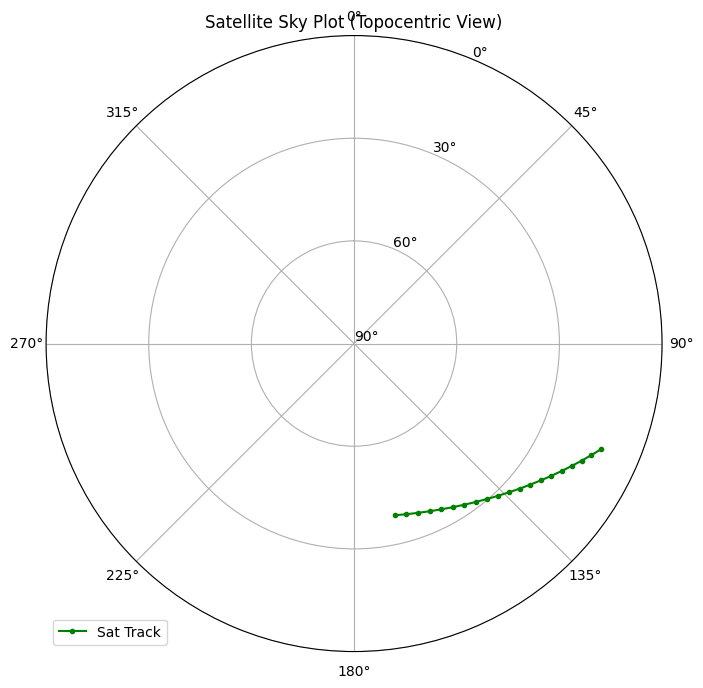

In [ ]:
#plot it
#sky plot

az_radians = np.radians(visible_az)

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

ax.plot(az_radians, visible_el, color='green', marker='o', markersize=3, label='Sat Track')


ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(bottom=90, top=0)
ax.set_yticks([0, 30, 60, 90])
ax.set_yticklabels(['0°', '30°', '60°', '90°'])

plt.title('Satellite Sky Plot (Topocentric View)')
plt.legend(loc='lower left')
plt.show()
